# Image classification for unbalanced datasets using standard scikit-learn models

I am working on a project for classification of medical images. The dataset is highly unbalanced. To test some quick ideas I am trying this exercise to apply some available models in scikit-learn to get some ideas about the approaches I may be able to take. The dataset for the other project is with 3D images and will be posted in another notebook.

In this notebook:
- Making an unbalanced dataset from MNIST dataset
- Trying Stochastic Gradient Descent classifier 
- Trying Random Forrest classifier
- creating a process for evaluating the result

## Loading the libraries

More relevant libraries will be added later:

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading the data and split to train and test

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]
y = [eval(i) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Creating an unbalanced dataset

We choose to make a classifier for number 5. Any data sample that is 5 is labeled 1 and others will be 0

In [3]:
y_train_5 = ([1 if y == 5 else 0 for y in y_train])
y_test_5 = [1 if y == 5 else 0 for y in y_test]

## Visualize the unbalanced data

Although it has been done in other notebooks:

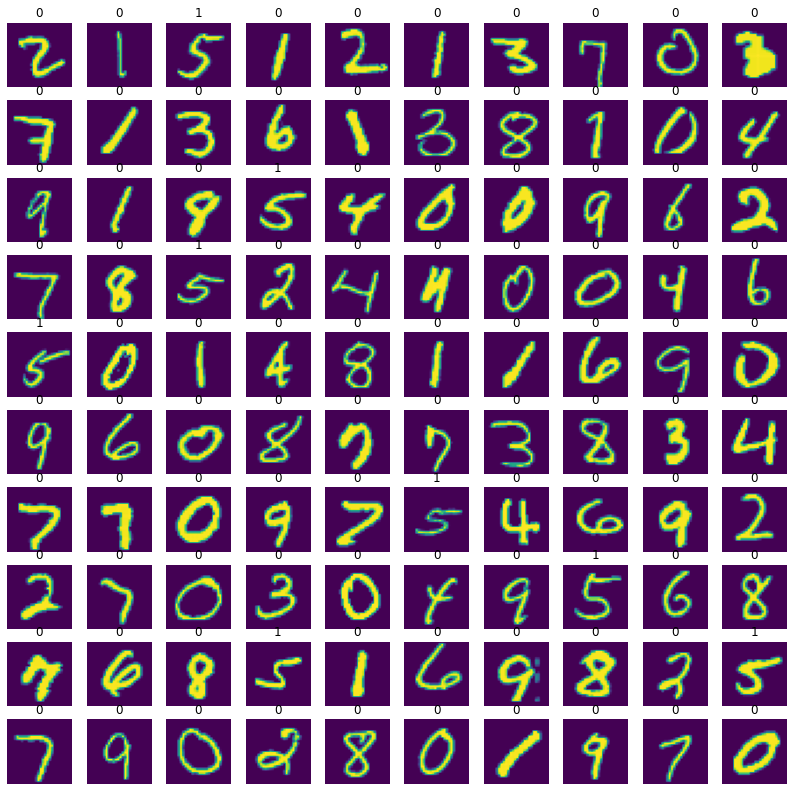

In [4]:
plt.figure(figsize=(14, 14))

for i in range(100):
    r = random.randint(0, len(X_train))
    ax = plt.subplot(10, 10, i + 1)
    image = np.resize(X_train[r], (28, 28))
    label = y_train_5[r]
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

### Trying SGDClassifier

For SGDClassifer there are several options for the loss [Link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html):

- Default is Hinge that results in a Linear SVM 
- LogLoss results in Logistic Regression
- Eplison_sensitive results in Support Vector Regression
- Squared Error results in Ridge Classifier

and there are some other options. We will use the default which results in a linear SVM

In [5]:
from sklearn.linear_model import SGDClassifier

Initialize and train by fitting the train data:

In [6]:
sgd_linear_svm = SGDClassifier(max_iter = 5000, tol = 1e-3)

In [7]:
sgd_linear_svm.fit(X_train, y_train_5)

SGDClassifier(max_iter=5000)

Getting predictions for the train and test datasets:

In [8]:
y_train_pred = sgd_linear_svm.predict(X_train)
y_test_pred = sgd_linear_svm.predict(X_test)

train_acc = (y_train_pred == y_train_5).sum() / len(y_train_pred)
print(f"Train accuracy: {train_acc}")
test_acc = (y_test_pred == y_test_5).sum() / len(y_test_pred)
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9621785714285714
Test accuracy: 0.9545714285714286


Although the accuracy looks good but this is a highly unbalanced dataset and a simple naive (like always 0) classifier can also give 90% accuracy. Therefore we should look at other metrics.

### Cross-validation

It is good practice to do a cross-validation on training datasets before checking the test dataset results.

In [9]:
from sklearn.model_selection import cross_val_score

In [10]:
cross_val_score(sgd_linear_svm, X_train, y_train_5, cv = 3 , scoring = 'accuracy')

array([0.96710773, 0.96630417, 0.9531769 ])

### Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)
#fig = plt.figure(figsize=(12, 12))
#plt.matshow(cm, cmap='binary', fignum=1, aspect='auto')

[[49498  1466]
 [  652  4384]]


### Precision, Recall, F1_score

In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_score: {f1}")

Precision: 0.7494017094017094
Recall: 0.8705321683876092
F1_score: 0.8054381774756567


### Precision vs. Recall. vs. Threshold

By choosing different thresholds we can change our decision about a class. We can see the usual trade-off between precision and recall and based on the requirements we can select a threshold.

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_linear_svm, X_train, y_train_5, cv = 3 , method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

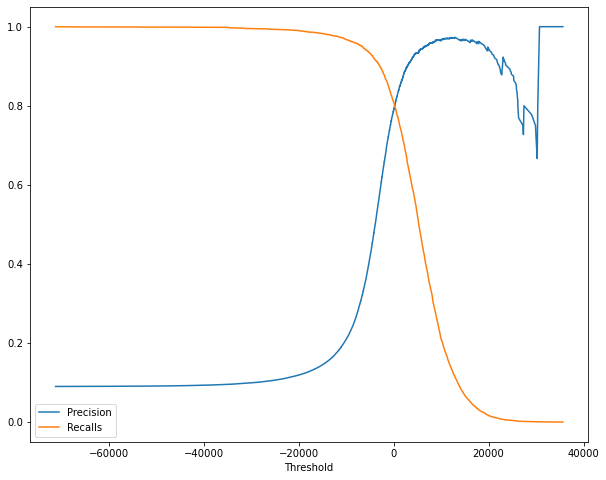

In [14]:
plt.figure(figsize = (10, 8))
plt.plot(thresholds, precisions[:-1], label = 'Precision')
plt.plot(thresholds, recalls[:-1], label = 'Recalls')
plt.xlabel('Threshold')
plt.legend()
plt.show()

We can also plot precision vs. Recal

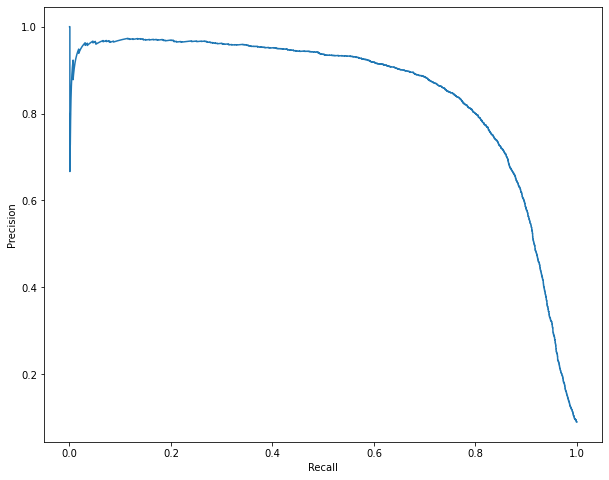

In [15]:
plt.figure(figsize = (10, 8))
plt.plot(recalls[:-1], precisions[:-1], label = 'Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### ROC curve

We also plot True Positive Rate (Recall) vs. True Negative Rate and calculate the area on the curve.

Area under curve score: 0.96251726210325


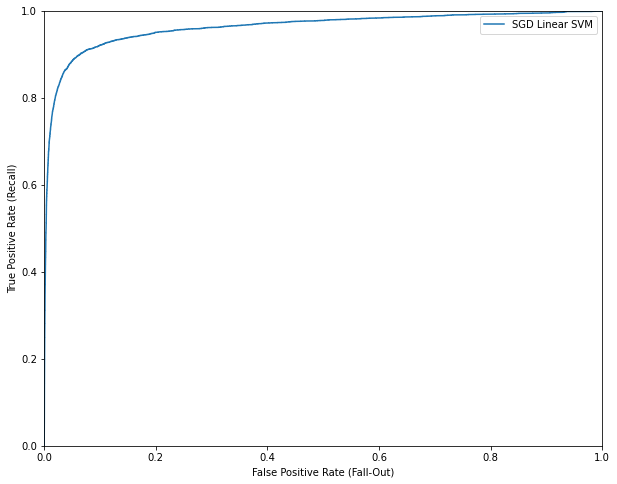

In [16]:
plt.figure(figsize = (10, 8))
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
AUC = roc_auc_score(y_train_5, y_scores)
print(f"Area under curve score: {AUC}")

FPR_sgd, TPR_sgd, _ = roc_curve(y_train_5,  y_scores)
plt.plot(FPR_sgd, TPR_sgd, label="SGD Linear SVM")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

### Trying Random Forrest Classifier

We do this to compare with SGD. The random forrest on MNIST was shown in another notebook.

In [17]:
from sklearn.ensemble import RandomForestClassifier

random_forrest = RandomForestClassifier(n_estimators = 100)
y_probes_rf = cross_val_predict(random_forrest, X_train, y_train_5, cv = 3, method = 'predict_proba')

y_scores_forrest = y_probes_rf[:, 1]

Area under curve score: 0.9986617895770186


<Figure size 720x576 with 0 Axes>

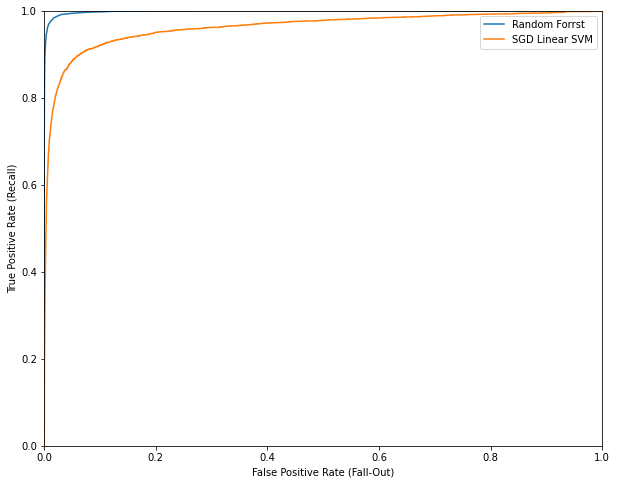

In [18]:
plt.figure(figsize = (10, 8))
AUC = roc_auc_score(y_train_5, y_scores_forrest)
print(f"Area under curve score: {AUC}")

plt.figure(figsize = (10, 8))
FPR_rf, TPR_rf, _ = roc_curve(y_train_5,  y_scores_forrest)
plt.plot(FPR_rf, TPR_rf, label = "Random Forrst")
plt.plot(FPR_sgd, TPR_sgd, label="SGD Linear SVM")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

We see that random forrest shows much better performance.

Summary: This notebook was to illustrate image classification for unbalanced datasets using scikit-learn standard classifiers as the first ideas. AutoML from Sagemaker can also be tried that will try many more options.

Multi-class classification on MNIST using different models is shown in another notebook.